# Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
import pathlib

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
#session.close()
session = InteractiveSession(config=config)

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
tf.__version__

'2.1.0'

In [6]:
tf.compat.v2.test.is_built_with_cuda()

False

## load dataset

In [18]:
data_dir = pathlib.Path('ressources/mapillary_raw/')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

1457

In [19]:
data_dir_validation = pathlib.Path('ressources/mapillary_raw/')
image_count_val = len(list(data_dir_validation.glob('*/*.jpg')))
image_count_val

1458

In [22]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if ((item.name != "LICENSE.txt") & (item.name != ".DS_Store"))])
CLASS_NAMES

array(['concrete', 'asphalt'], dtype='<U8')

In [23]:
for path in CLASS_NAMES:
    print(path + ": " + str(len(list(data_dir.glob(path+'/*.jpg')))))

concrete: 115
asphalt: 1379


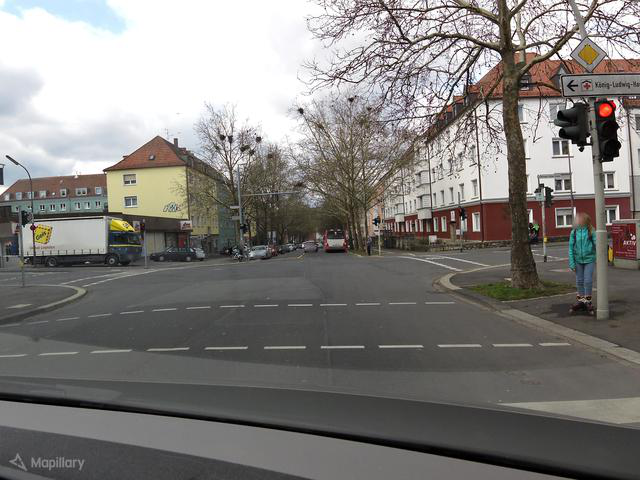

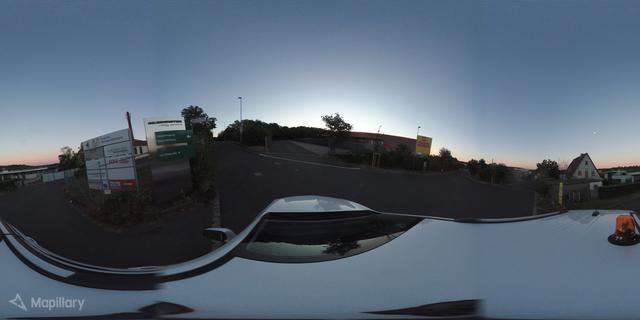

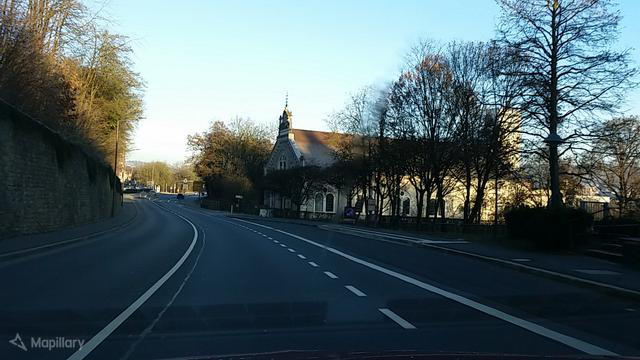

In [24]:
dirt = list(data_dir.glob('asphalt/*'))

for image_path in dirt[:3]:
    display.display(Image.open(str(image_path)))


In [30]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [31]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_validation/'*/*'))


In [32]:
for f in list_ds.take(5):
  print(f.numpy())


b'ressources/mapillary_raw/asphalt/PwsxKSpuTpooVxfnyZgISQ.jpg'
b'ressources/mapillary_raw/asphalt/1qhI7pBV-s-EkYfPYkyAxQ.jpg'
b'ressources/mapillary_raw/asphalt/O4Pqbm7-0ERvW9GvWTcCsg.jpg'
b'ressources/mapillary_raw/asphalt/CF5eK0oCbahLUtvqzHwm-w.jpg'
b'ressources/mapillary_raw/asphalt/-F0aFbs0y4QsX7zu9VjeCg.jpg'


In [33]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [34]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_val = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (160, 160, 3)
Label:  [False  True]


In [35]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               #rotation_range=45,
                               #zoom_range=0.5,
                               #width_shift_range=.15,
                               #height_shift_range=.15,
)


In [36]:
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=data_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))


Found 1555 images belonging to 2 classes.


In [37]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


In [38]:
def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  #ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [39]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [40]:
train_ds = prepare_for_training(labeled_ds)

validation_ds = prepare_for_validation(labeled_ds_val)

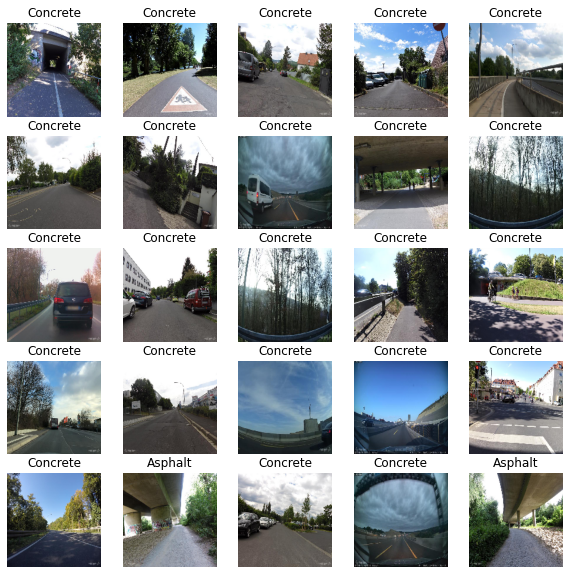

In [41]:
image_batch, label_batch = next(iter(train_data_gen))

show_batch(image_batch, label_batch)

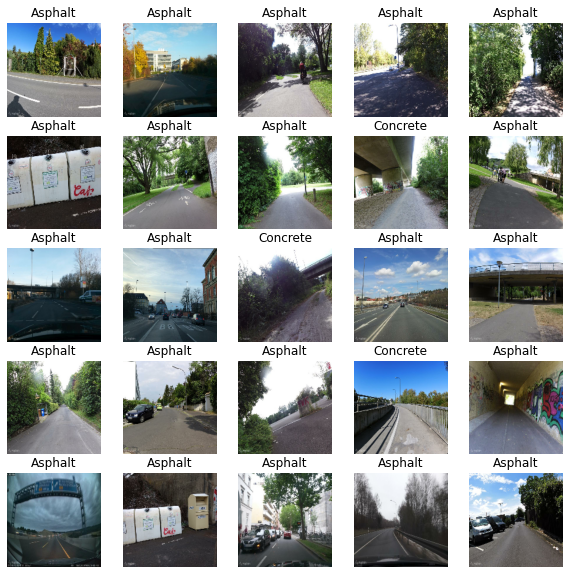

In [42]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


# create model

In [15]:
print(train_ds)


NameError: name 'train_ds' is not defined

In [16]:
for image_batch, label_batch in train_ds.take(1):
   pass

image_batch.shape

NameError: name 'train_ds' is not defined

In [17]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


NameError: name 'tf' is not defined

In [18]:
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.cuda_version_number)
print(tf_build_info.cudnn_version_number)


ModuleNotFoundError: No module named 'tensorflow'

In [19]:

feature_batch = base_model(image_batch)
print(feature_batch.shape)


NameError: name 'base_model' is not defined

In [20]:
base_model.trainable = False

NameError: name 'base_model' is not defined

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

NameError: name 'base_model' is not defined

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

NameError: name 'tf' is not defined

In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

NameError: name 'tf' is not defined

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


NameError: name 'tf' is not defined

In [25]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [26]:
model.summary()

NameError: name 'model' is not defined

## training process

In [27]:
initial_epochs = 10
steps_per_epoch = round(image_count)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)


NameError: name 'image_count' is not defined

In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


NameError: name 'loss0' is not defined

In [29]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    steps_per_epoch=50,
                    validation_freq=2,
                    validation_steps=5)


NameError: name 'model' is not defined

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


NameError: name 'history' is not defined

In [31]:
base_model.trainable = True

NameError: name 'base_model' is not defined

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


NameError: name 'base_model' is not defined

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


NameError: name 'model' is not defined

In [34]:
model.summary()

NameError: name 'model' is not defined

In [35]:
len(model.trainable_variables)


NameError: name 'model' is not defined

In [36]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=fine_tune_epochs,
                    validation_data=validation_ds,
                    steps_per_epoch=50,
                   # validation_freq=2,
                    validation_steps=5)


NameError: name 'model' is not defined

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


NameError: name 'acc' is not defined

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


NameError: name 'plt' is not defined

In [39]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [40]:
val_pred = model.predict(validation_ds)

NameError: name 'model' is not defined

In [41]:
pd.DataFrame(val_pred)

NameError: name 'pd' is not defined

mode